# 2019 data, not 2020, same structure as Models

In [36]:
# https://www.kaggle.com/humburgc/history-eda-machine-learning-march-madness
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
# To properly do ‘pip install bracketeer’, you’ll need to first
# pip install binarytree
# Pip install Pillow
# Pip install bracketeer
from bracketeer import build_bracket
from IPython.display import Image
import eli5
from eli5.sklearn import PermutationImportance

pd.set_option('display.max_columns', None)

## Build Data For Model Input

In [37]:
# currently in folder /Ryan
df = pd.read_csv('../2019Data/Stage2DataFiles/RegularSeasonDetailedResults.csv')
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [38]:
# Create DataFrame with merged csv files for efficiency. 
df = df.drop(['WLoc', 'NumOT'], axis=1)

# Save dataframes with Team and Conference names:
df_teams = pd.read_csv('../2019Data/Stage2DataFiles/Teams.csv')
df_team_conferences = pd.read_csv('../2019Data/Stage2DataFiles/TeamConferences.csv')
df_conferences = pd.read_csv('../2019Data/Stage2DataFiles/Conferences.csv')

In [39]:
# Merge the conference dataframes to eventually use the full conference name:
df_conference_names = df_team_conferences.merge(df_conferences, on=['ConfAbbrev'])

# Pre-merge tidying to match with winner and loser IDs:
win_teams = df_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_conference_names.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_conference_names.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

# Merge winning team name and conference, losing team name and conference with season results:
df = df.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})
print(df.shape)
df.tail()

(87504, 36)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
87499,2019,117,1430,64,1465,63,22,62,6,21,14,18,20,25,6,13,5,2,13,25,63,8,25,5,7,14,23,9,11,4,5,20,Utah Valley,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87500,2019,80,1167,88,1465,84,35,77,6,19,12,16,23,22,16,12,11,3,16,30,61,11,32,13,16,10,20,11,15,7,3,16,CS Bakersfield,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87501,2019,115,1370,67,1465,65,27,61,8,22,5,7,12,28,10,13,3,3,20,17,53,6,20,25,32,12,23,6,7,8,4,13,Seattle,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87502,2019,82,1213,90,1465,73,34,66,7,23,15,22,14,20,12,6,10,1,21,25,49,11,20,12,17,6,21,14,16,1,3,20,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87503,2019,108,1213,91,1465,58,30,59,13,29,18,20,7,30,21,10,8,5,15,23,62,5,26,7,8,10,24,6,17,3,1,15,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference


In [40]:
df.tail()
# WFGM - field goals made (by the winning team)
# WFGA - field goals attempted (by the winning team)
# WFGM3 - three pointers made (by the winning team)
# WFGA3 - three pointers attempted (by the winning team)
# WFTM - free throws made (by the winning team)
# WFTA - free throws attempted (by the winning team)
# WOR - offensive rebounds (pulled by the winning team)
# WDR - defensive rebounds (pulled by the winning team)
# WAst - assists (by the winning team)
# WTO - turnovers committed (by the winning team)
# WStl - steals (accomplished by the winning team)
# WBlk - blocks (accomplished by the winning team)
# WPF - personal fouls committed (by the winning team)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
87499,2019,117,1430,64,1465,63,22,62,6,21,14,18,20,25,6,13,5,2,13,25,63,8,25,5,7,14,23,9,11,4,5,20,Utah Valley,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87500,2019,80,1167,88,1465,84,35,77,6,19,12,16,23,22,16,12,11,3,16,30,61,11,32,13,16,10,20,11,15,7,3,16,CS Bakersfield,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87501,2019,115,1370,67,1465,65,27,61,8,22,5,7,12,28,10,13,3,3,20,17,53,6,20,25,32,12,23,6,7,8,4,13,Seattle,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87502,2019,82,1213,90,1465,73,34,66,7,23,15,22,14,20,12,6,10,1,21,25,49,11,20,12,17,6,21,14,16,1,3,20,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference
87503,2019,108,1213,91,1465,58,30,59,13,29,18,20,7,30,21,10,8,5,15,23,62,5,26,7,8,10,24,6,17,3,1,15,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference


In [41]:
df.Season.unique()

array([2003, 2007, 2018, 2008, 2017, 2004, 2006, 2009, 2010, 2011, 2012,
       2013, 2016, 2019, 2015, 2014, 2005], dtype=int64)

In [42]:
df['WFGM2'] = df.WFGM - df.WFGM3
df['WFGA2'] = df.WFGA - df.WFGA3
df['LFGM2'] = df.LFGM - df.LFGM3
df['LFGA2'] = df.LFGA - df.LFGA3
print('These are the {} conferences that have participated in NCAA Division I men’s basketball since 2009, including the number of wins in the dataframe for each:'.format(len(df.WConfName.value_counts())))
df.WConfName.value_counts()

These are the 36 conferences that have participated in NCAA Division I men’s basketball since 2009, including the number of wins in the dataframe for each:


Big East Conference                   4310
Atlantic Coast Conference             4175
Southeastern Conference               4081
Big Ten Conference                    3893
Atlantic 10 Conference                3882
Big 12 Conference                     3608
Conference USA                        3514
Mid-American Conference               3141
Colonial Athletic Association         2823
Sun Belt Conference                   2811
Missouri Valley Conference            2807
Mountain West Conference              2727
Metro Atlantic Athletic Conference    2624
Southern Conference                   2544
Ohio Valley Conference                2460
Northeast Conference                  2450
Southland Conference                  2433
Horizon League                        2374
Mid-Eastern Athletic Conference       2352
West Coast Conference                 2343
Western Athletic Conference           2284
Atlantic Sun Conference               2216
America East Conference               2119
Big Sky Con

In [43]:
# Check winner boxscore data needed to calculate stats:
df[['WFGA', 'WFTA', 'WTO', 'WOR', 'WScore', 'WFGM2', 'WFGM3', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF']].describe()

,WFGA,WFTA,WTO,WOR,WScore,WFGM2,WFGM3,WFGM,WFTM,WDR,WAst,WStl,WBlk,WPF
count,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000
mean,55.174266,22.659113,12.975464,10.900290,75.429580,18.996846,7.114646,26.111492,16.091950,25.677066,14.738423,7.008777,3.830899,17.451477
std,7.564707,8.123213,4.026165,4.132544,11.131958,4.691893,3.070932,4.700220,6.249622,4.909033,4.412361,3.123401,2.460668,4.136628
min,27.000000,0.000000,1.000000,0.000000,34.000000,2.000000,0.000000,10.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000
25%,50.000000,17.000000,10.000000,8.000000,68.000000,16.000000,5.000000,23.000000,12.000000,22.000000,12.000000,5.000000,2.000000,15.000000
50%,55.000000,22.000000,13.000000,11.000000,75.000000,19.000000,7.000000,26.000000,16.000000,26.000000,14.000000,7.000000,3.000000,17.000000
75%,60.000000,28.000000,16.000000,13.000000,82.000000,22.000000,9.000000,29.000000,20.000000,29.000000,18.000000,9.000000,5.000000,20.000000
max,103.000000,67.000000,33.000000,38.000000,144.000000,48.000000,26.000000,56.000000,48.000000,53.000000,40.000000,26.000000,21.000000,41.000000


In [44]:
# Check loser boxscore data needed to calculate stats:
df[['LFGA', 'LFTA', 'LTO', 'LOR', 'LScore', 'LFGM2', 'LFGM3', 'LFGM', 'LFTM', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF']].describe()

,LFGA,LFTA,LTO,LOR,LScore,LFGM2,LFGM3,LFGM,LFTM,LDR,LAst,LStl,LBlk,LPF
count,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000
mean,56.392691,18.039244,14.313826,11.115526,63.437866,16.538307,6.058043,22.596350,12.187123,21.631525,11.439706,6.008422,2.870749,19.766811
std,7.686611,7.143685,4.407597,4.207721,10.974796,4.307365,2.781245,4.388046,5.368036,4.543547,3.732508,2.766675,2.037376,4.528199
min,26.000000,0.000000,0.000000,0.000000,20.000000,2.000000,0.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000
25%,51.000000,13.000000,11.000000,8.000000,56.000000,14.000000,4.000000,20.000000,8.000000,19.000000,9.000000,4.000000,1.000000,17.000000
50%,56.000000,18.000000,14.000000,11.000000,63.000000,16.000000,6.000000,22.000000,12.000000,21.000000,11.000000,6.000000,3.000000,20.000000
75%,61.000000,23.000000,17.000000,14.000000,70.000000,19.000000,8.000000,25.000000,16.000000,25.000000,14.000000,8.000000,4.000000,23.000000
max,106.000000,61.000000,41.000000,36.000000,140.000000,40.000000,22.000000,47.000000,42.000000,49.000000,31.000000,22.000000,18.000000,45.000000


In [45]:
# Winner stats related to offensive efficiency:
df['Wposs'] = df.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df['Wshoot_eff'] = df.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df['Wscore_op'] = df.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df['Woff_rtg'] = df.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df['Lposs'] = df.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df['Lshoot_eff'] = df.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df['Lscore_op'] = df.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df['Loff_rtg'] = df.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df['Wdef_rtg'] = df.apply(lambda row: row.Loff_rtg, axis=1)
df['Wsos'] = df.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df['Ldef_rtg'] = df.apply(lambda row: row.Woff_rtg, axis=1)
df['Lsos'] = df.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df['Wie'] = Wie / (Wie + Lie) * 100
df['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df['Wts_pct'] = df.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df['Wefg_pct'] = df.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df['Worb_pct'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['Wdrb_pct'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['Wreb_pct'] = df.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df['Wto_poss'] = df.apply(lambda row: row.WTO / row.Wposs, axis=1)
df['Wft_rate'] = df.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df['Wast_rtio'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df['Wblk_pct'] = df.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df['Wstl_pct'] = df.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)
df['W3pta_pct'] = df.apply(lambda row: row.WFGA3 / row.WFGA * 100, axis=1)

# Other loser stats:
df['Lts_pct'] = df.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df['Lefg_pct'] = df.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df['Lorb_pct'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df['Ldrb_pct'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df['Lreb_pct'] = df.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df['Lto_poss'] = df.apply(lambda row: row.LTO / row.Lposs, axis=1)
df['Lft_rate'] = df.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df['Last_rtio'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df['Lblk_pct'] = df.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df['Lstl_pct'] = df.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
df['L3pta_pct'] = df.apply(lambda row: row.LFGA3 / row.LFGA * 100, axis=1)

# Calculate weighted factors for winners and losers:
df['Wfour'] = df.apply(lambda row: 0.4*row.Wefg_pct + 0.25*row.Wto_poss + 0.2*row.Worb_pct + 0.15*row.Wft_rate, axis=1)
df['Lfour'] = df.apply(lambda row: 0.4*row.Lefg_pct + 0.25*row.Lto_poss + 0.2*row.Lorb_pct + 0.15*row.Lft_rate, axis=1)


In [46]:
df.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName,WFGM2,WFGA2,LFGM2,LFGA2,Wposs,Wshoot_eff,Wscore_op,Woff_rtg,Lposs,Lshoot_eff,Lscore_op,Loff_rtg,Wdef_rtg,Wsos,Ldef_rtg,Lsos,Wie,Lie,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wast_rtio,Wblk_pct,Wstl_pct,W3pta_pct,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Last_rtio,Lblk_pct,Lstl_pct,L3pta_pct,Wfour,Lfour
87499,2019,117,1430,64,1465,63,22,62,6,21,14,18,20,25,6,13,5,2,13,25,63,8,25,5,7,14,23,9,11,4,5,20,Utah Valley,Western Athletic Conference,Cal Baptist,Western Athletic Conference,16,41,17,38,63.550,0.907158,1.110149,100.708104,63.325,0.949868,1.047375,99.486775,99.486775,1.221329,100.708104,-1.221329,52.229299,47.770701,45.357902,0.403226,0.465116,0.641026,0.553071,0.204563,0.225806,6.700168,5.263158,7.895776,33.870968,47.493404,0.460317,0.358974,0.534884,0.446929,0.173707,0.079365,10.425717,12.195122,6.294256,39.682540,0.339325,0.311253
87500,2019,80,1167,88,1465,84,35,77,6,19,12,16,23,22,16,12,11,3,16,30,61,11,32,13,16,10,20,11,15,7,3,16,CS Bakersfield,Western Athletic Conference,Cal Baptist,Western Athletic Conference,29,58,19,29,73.600,1.040189,1.149457,119.565217,73.600,1.224490,0.932065,114.130435,114.130435,5.434783,119.565217,-5.434783,54.480287,45.519713,52.009456,0.493506,0.534884,0.687500,0.611192,0.163043,0.155844,14.209591,10.344828,14.945652,24.675325,61.224490,0.581967,0.312500,0.465116,0.388808,0.203804,0.213115,11.627907,5.172414,9.510870,52.459016,0.368517,0.378205
87501,2019,115,1370,67,1465,65,27,61,8,22,5,7,12,28,10,13,3,3,20,17,53,6,20,25,32,12,23,6,7,8,4,13,Seattle,Western Athletic Conference,Cal Baptist,Western Athletic Conference,19,39,11,33,65.325,1.041586,0.984692,102.564103,63.200,0.953079,1.079114,102.848101,102.848101,-0.283999,102.564103,0.283999,49.732620,50.267380,52.079285,0.508197,0.342857,0.700000,0.521429,0.199005,0.081967,11.451474,9.090909,4.746835,36.065574,47.653959,0.377358,0.300000,0.657143,0.478571,0.110759,0.471698,7.389163,10.256410,12.246460,37.735849,0.333896,0.309388
87502,2019,82,1213,90,1465,73,34,66,7,23,15,22,14,20,12,6,10,1,21,25,49,11,20,12,17,6,21,14,16,1,3,20,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference,27,43,14,29,68.450,1.177240,1.116874,131.482834,67.075,1.279019,0.850913,108.833395,108.833395,22.649439,131.482834,-22.649439,60.245902,39.754098,58.862001,0.568182,0.400000,0.769231,0.584615,0.087655,0.227273,12.705135,3.448276,14.908684,34.848485,63.950942,0.622449,0.230769,0.600000,0.415385,0.238539,0.244898,16.078094,6.976744,1.460920,40.816327,0.363277,0.391503
87503,2019,108,1213,91,1465,58,30,59,13,29,18,20,7,30,21,10,8,5,15,23,62,5,26,7,8,10,24,6,17,3,1,15,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference,17,30,18,36,71.500,1.328467,0.958042,127.272727,72.800,0.881459,0.903846,79.670330,79.670330,47.602398,127.272727,-47.602398,80.321285,19.678715,66.423358,0.618644,0.225806,0.750000,0.487903,0.139860,0.305085,21.105528,13.888889,10.989011,49.152542,44.072948,0.411290,0.250000,0.774194,0.512097,0.233516,0.112903,6.756757,3.333333,4.195804,41.935484,0.373347,0.289831


## Regular Season Averages

In [47]:
# Initialize dataframe to hold season averages:
df_avgs = pd.DataFrame()

# Get and save number of wins and losses:
df_avgs['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
df_avgs['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

df_avgs['n_loss'].fillna(0, inplace=True)

# Calculate win percentages:
df_avgs['win_pct'] = df_avgs['n_wins'] / (df_avgs['n_wins'] + df_avgs['n_loss'])

In [48]:
# Calculate averages for games won:
df_avgs['Wshoot_eff'] = df['Wshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wscore_op'] = df['Wscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Woff_rtg'] = df['Woff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdef_rtg'] = df['Wdef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wsos'] = df['Wsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wts_pct'] = df['Wts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wefg_pct'] = df['Wefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Worb_pct'] = df['Worb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdrb_pct'] = df['Wdrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wreb_pct'] = df['Wreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wto_poss'] = df['Wto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wft_rate'] = df['Wft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wie'] = df['Wie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wast_rtio'] = df['Wast_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wblk_pct'] = df['Wblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wstl_pct'] = df['Wstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['W3pta_pct'] = df['W3pta_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wfour'] = df['Wfour'].groupby([df['Season'], df['WTeamID']]).mean()

# Calculate averages for games lost:
df_avgs['Lshoot_eff'] = df['Lshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lscore_op'] = df['Lscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Loff_rtg'] = df['Loff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldef_rtg'] = df['Ldef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lsos'] = df['Lsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lts_pct'] = df['Lts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lefg_pct'] = df['Lefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lorb_pct'] = df['Lorb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldrb_pct'] = df['Ldrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lreb_pct'] = df['Lreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lto_poss'] = df['Lto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lft_rate'] = df['Lft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lie'] = df['Lie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Last_rtio'] = df['Last_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lblk_pct'] = df['Lblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lstl_pct'] = df['Lstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['L3pta_pct'] = df['L3pta_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lfour'] = df['Lfour'].groupby([df['Season'], df['WTeamID']]).mean()

In [49]:
# Calculate weighted average using win percentage:
df_avgs['shoot_eff'] = df_avgs['Wshoot_eff'] * df_avgs['win_pct'] + df_avgs['Lshoot_eff'] * (1 - df_avgs['win_pct'])
df_avgs['score_op'] = df_avgs['Wscore_op'] * df_avgs['win_pct'] + df_avgs['Lscore_op'] * (1 - df_avgs['win_pct'])
df_avgs['off_rtg'] = df_avgs['Woff_rtg'] * df_avgs['win_pct'] + df_avgs['Loff_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['def_rtg'] = df_avgs['Wdef_rtg'] * df_avgs['win_pct'] + df_avgs['Ldef_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['sos'] = df_avgs['Wsos'] * df_avgs['win_pct'] + df_avgs['Lsos'] * (1 - df_avgs['win_pct'])
df_avgs['ts_pct'] = df_avgs['Wts_pct'] * df_avgs['win_pct'] + df_avgs['Lts_pct'] * (1 - df_avgs['win_pct'])
df_avgs['efg_pct'] = df_avgs['Wefg_pct'] * df_avgs['win_pct'] + df_avgs['Lefg_pct'] * (1 - df_avgs['win_pct'])
df_avgs['orb_pct'] = df_avgs['Worb_pct'] * df_avgs['win_pct'] + df_avgs['Lorb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['drb_pct'] = df_avgs['Wdrb_pct'] * df_avgs['win_pct'] + df_avgs['Ldrb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['reb_pct'] = df_avgs['Wreb_pct'] * df_avgs['win_pct'] + df_avgs['Lreb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['to_poss'] = df_avgs['Wto_poss'] * df_avgs['win_pct'] + df_avgs['Lto_poss'] * (1 - df_avgs['win_pct'])
df_avgs['ft_rate'] = df_avgs['Wft_rate'] * df_avgs['win_pct'] + df_avgs['Lft_rate'] * (1 - df_avgs['win_pct'])
df_avgs['ie'] = df_avgs['Wie'] * df_avgs['win_pct'] + df_avgs['Lie'] * (1 - df_avgs['win_pct'])
df_avgs['ast_rtio'] = df_avgs['Wast_rtio'] * df_avgs['win_pct'] + df_avgs['Last_rtio'] * (1 - df_avgs['win_pct'])
df_avgs['blk_pct'] = df_avgs['Wblk_pct'] * df_avgs['win_pct'] + df_avgs['Lblk_pct'] * (1 - df_avgs['win_pct'])
df_avgs['stl_pct'] = df_avgs['Wstl_pct'] * df_avgs['win_pct'] + df_avgs['Lstl_pct'] * (1 - df_avgs['win_pct'])
df_avgs['3pta_pct'] = df_avgs['W3pta_pct'] * df_avgs['win_pct'] + df_avgs['L3pta_pct'] * (1 - df_avgs['win_pct'])
df_avgs['four'] = df_avgs['Wfour'] * df_avgs['win_pct'] + df_avgs['Lfour'] * (1 - df_avgs['win_pct'])

df_avgs.reset_index(inplace = True)
df_avgs = df_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
df_avgs.tail()

,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Wscore_op,Woff_rtg,Wdef_rtg,Wsos,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wie,Wast_rtio,Wblk_pct,Wstl_pct,W3pta_pct,Wfour,Lshoot_eff,Lscore_op,Loff_rtg,Ldef_rtg,Lsos,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Lie,Last_rtio,Lblk_pct,Lstl_pct,L3pta_pct,Lfour,shoot_eff,score_op,off_rtg,def_rtg,sos,ts_pct,efg_pct,orb_pct,drb_pct,reb_pct,to_poss,ft_rate,ie,ast_rtio,blk_pct,stl_pct,3pta_pct,four
5824,2019,1462,Xavier,Big East Conference,18,15.0,0.545455,1.186299,0.966071,113.702993,97.508519,16.194474,59.314953,0.571949,0.322905,0.760014,0.541460,0.187203,0.259616,62.027711,17.134817,13.455649,8.928508,38.098307,0.379104,1.011631,0.967515,97.508519,113.702993,-16.194474,50.581573,0.483834,0.239986,0.677095,0.458540,0.167846,0.157340,37.972289,15.231050,6.516815,10.248072,43.526730,0.307093,1.106905,0.966727,106.341868,104.869643,1.472225,55.345235,0.531897,0.285214,0.722324,0.503769,0.178405,0.213127,51.093428,16.269469,10.301634,9.528310,40.565772,0.346372
5825,2019,1463,Yale,Ivy League,21,7.0,0.750000,1.213663,0.947431,115.074150,95.508803,19.565347,60.683130,0.584646,0.274817,0.764422,0.519619,0.175416,0.232637,64.518727,17.875068,12.069750,7.594496,33.316477,0.367572,0.971129,0.984085,95.508803,115.074150,-19.565347,48.556443,0.446819,0.235578,0.725183,0.480381,0.147987,0.211455,35.481273,12.195694,6.159349,9.094465,37.603254,0.294558,1.153029,0.956594,110.182813,100.400140,9.782674,57.651458,0.550190,0.265007,0.754612,0.509810,0.168559,0.227342,57.259363,16.455224,10.592150,7.969488,34.388171,0.349318
5826,2019,1464,Youngstown St,Horizon League,10,20.0,0.333333,1.093867,1.039320,113.263821,100.391627,12.872194,54.693359,0.520336,0.329702,0.734922,0.532312,0.143127,0.192610,56.240491,15.814893,8.731017,10.285590,43.282943,0.338748,1.035919,0.969706,100.391627,113.263821,-12.872194,51.795937,0.473062,0.265078,0.670298,0.467688,0.164462,0.261234,43.759509,13.078788,9.629200,5.334534,36.761068,0.322541,1.055235,0.992911,104.682358,108.973089,-4.290731,52.761744,0.488820,0.286620,0.691839,0.489229,0.157350,0.238359,47.919836,13.990823,9.329806,6.984886,38.935027,0.327943
5827,2019,1465,Cal Baptist,Western Athletic Conference,12,14.0,0.461538,1.210790,0.983146,118.063533,96.438097,21.625436,60.539476,0.564634,0.293847,0.729418,0.511632,0.157162,0.289525,62.828485,12.269812,6.903191,6.467221,42.105237,0.367342,0.988599,0.980386,96.438097,118.063533,-21.625436,49.429958,0.452800,0.270582,0.706153,0.488368,0.173803,0.260060,37.171515,11.341271,7.523023,5.762367,29.865114,0.317696,1.091149,0.981660,106.419068,108.082563,-1.663495,54.557428,0.504416,0.281320,0.716891,0.499105,0.166123,0.273659,49.013193,11.769828,7.236947,6.087684,35.514401,0.340610
5828,2019,1466,North Alabama,Atlantic Sun Conference,7,22.0,0.241379,1.028284,0.981491,100.483245,91.167889,9.315356,51.414185,0.480021,0.288811,0.718952,0.503881,0.181728,0.227626,54.526085,12.180341,8.517166,10.193792,39.866103,0.329346,0.958200,0.953140,91.167889,100.483245,-9.315356,47.910022,0.430156,0.281048,0.711189,0.496119,0.198591,0.285454,45.473915,10.646408,11.737645,7.958882,30.364905,0.320738,0.975117,0.959983,93.416423,98.234710,-4.818287,48.755855,0.442192,0.282922,0.713063,0.497992,0.194520,0.271496,47.658922,11.016668,10.960288,8.498343,32.658298,0.322816


In [50]:
def tourn_round(DayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif DayNum == 152:
        return 4
    elif DayNum == 154:
        return 2
    else:
        return 68
    
df_tourney_all = pd.read_csv('../2019Data/Stage2DataFiles/NCAATourneyCompactResults.csv')
df_tourney_all['tourn_round'] = df_tourney_all.DayNum.apply(tourn_round)
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round
0,1985,136,1116,63,1234,54,N,0,64
1,1985,136,1120,59,1345,58,N,0,64
2,1985,136,1207,68,1250,43,N,0,64
3,1985,136,1229,58,1425,55,N,0,64
4,1985,136,1242,49,1325,38,N,0,64


In [51]:
past_trny_teams = list(set(list(df_tourney_all.WTeamID.unique()) + list(df_tourney_all.LTeamID.unique()))) 
print(len(past_trny_teams))

df_predict = pd.read_csv('../2019Data/SampleSubmissionStage2.csv')
grp1 = list(set(df_predict.apply(lambda row: row.ID.split('_')[1], axis=1)))
grp2 = list(set(df_predict.apply(lambda row: row.ID.split('_')[2], axis=1)))
crnt_trny_teams = list(set(grp1 + grp2))
print(len(crnt_trny_teams))

298
68


In [52]:
df_seeds = pd.read_csv('../2019Data/Stage2DataFiles/NCAATourneySeeds.csv')

# Get the seed number by taking the last two characters of 'Seed' values:
df_seeds['seed'] = df_seeds['Seed'].apply(lambda x : int(x[1:3]))
df_seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [53]:
# Drop the old 'Seed' column:
df_seeds = df_seeds[['Season', 'TeamID', 'seed']]

# Merge seeds, team names, and conference names with tournament data:
df_tourney_all = df_tourney_all.merge(df_seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_tourney_all['point_diff'] = df_tourney_all.WScore - df_tourney_all.LScore

In [54]:
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
0,1985,136,1116,63,1234,54,N,0,64,9,8,Arkansas,Southwest Conference,Iowa,Big Ten Conference,9
1,1997,138,1246,75,1234,69,N,0,32,1,8,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,6
2,2001,138,1246,92,1234,79,N,0,32,2,7,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,13
3,1987,146,1424,84,1234,81,N,0,8,1,2,UNLV,Pacific Coast Athletic Association,Iowa,Big Ten Conference,3
4,1991,138,1181,85,1234,70,N,0,32,2,7,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,15


In [55]:
#f_features = df_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four', 'POM', 'RPI']]
df_features = df_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four']]
df_features.head()

,Season,TeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four
0,2003,1102,1.157992,0.912308,104.865089,108.891909,-4.026821,46.353379,0.556399,0.224084,0.281494,0.281172,0.513663,0.745833,57.899587,15.043055,6.244552,11.339317,40.063518,0.377055
1,2003,1103,1.178634,0.960977,113.080027,113.577449,-0.497421,49.572422,0.549879,0.195595,0.350337,0.342413,0.501137,0.651936,58.931685,15.515524,5.381451,9.435123,30.212069,0.390280
2,2003,1104,1.032297,0.981914,101.342274,97.144558,4.197716,53.381854,0.479505,0.201484,0.339413,0.246554,0.507537,0.675662,51.614839,13.517660,9.456247,9.357466,35.072276,0.347039
3,2003,1105,0.992582,0.905364,90.226256,97.916657,-7.690401,43.479539,0.448906,0.268965,0.346065,0.296038,0.488291,0.630517,49.629125,12.671506,8.882001,10.655837,32.353195,0.360422
4,2003,1106,0.974301,0.934496,90.752040,91.918235,-1.166195,48.275840,0.446706,0.242880,0.329124,0.279248,0.496678,0.664233,48.715074,11.779535,7.753222,12.994214,27.987716,0.347114


In [56]:
df_seeds = df_seeds[df_seeds.Season > 2008]
df_features = pd.merge(df_seeds, df_features, how='left', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])

df_features['seed'] = pd.Categorical(df_features.seed)
df_dummies = pd.get_dummies(df_features.seed, prefix='seed')
df_features = pd.concat([df_features, df_dummies], axis=1)
df_features.drop(['seed'], inplace=True, axis=1)

In [57]:
df_features.Season.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [59]:
df_features.to_csv('../2019Data/df_features.csv', index=False)

In [60]:
df_tourney = df_tourney_all[df_tourney_all.Season > 2008]
df_tourney.reset_index(inplace=True, drop=True)
df_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
659,2018,136,1211,68,1422,64,N,0,64,4,13,Gonzaga,West Coast Conference,UNC Greensboro,Southern Conference,4
660,2017,138,1211,79,1321,73,N,0,32,1,8,Gonzaga,West Coast Conference,Northwestern,Big Ten Conference,6
661,2014,137,1455,64,1142,37,N,0,64,1,16,Wichita St,Missouri Valley Conference,Cal Poly SLO,Big West Conference,27
662,2011,136,1361,68,1294,50,N,0,64,2,15,San Diego St,Mountain West Conference,N Colorado,Big Sky Conference,18
663,2015,135,1352,81,1316,77,N,0,68,16,16,Robert Morris,Northeast Conference,North Florida,Atlantic Sun Conference,4


In [61]:
# Merge tourney games with tourney winners' season features:
df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_winners.drop(['TeamID'], inplace=True, axis=1) 

# Merge tourney games with loser features:
df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_losers.drop(['TeamID'], inplace=True, axis=1)

# Build Model

In [62]:
# Create winner target by subtracting loser data from winner data,
# and assigning a value of 1:
df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
df_winner_diff['result'] = 1

# Create loser target by subtracting winner data from loser data,
# and assigning a value of 0:
df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
df_loser_diff['result'] = 0

# Concatenate winner data with loser data:
df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)
df_model.head()

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,result
0,0.075837,-0.041414,2.472499,-7.025353,9.497851,7.464473,0.029454,0.017600,-0.022644,0.047231,0.004361,0.031366,3.791866,0.915826,-2.658720,0.469603,5.985310,0.018737,0,1,0,0,0,0,255,0,0,0,0,0,0,0,0,0,1
1,0.155790,-0.001440,15.351639,-1.643518,16.995157,13.101788,0.099832,-0.027069,-0.012423,-0.003688,0.011962,0.036347,7.789490,2.437619,-3.268603,-1.766893,-1.734220,0.030128,0,1,0,0,0,0,255,0,0,0,0,0,0,0,0,0,1
2,-0.006739,0.008351,0.429112,0.538735,-0.109623,-0.477634,0.001875,-0.003461,-0.004103,-0.043540,0.001232,0.006566,-0.336961,-1.260066,-0.127182,-1.078380,-1.308214,-0.007467,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.011290,0.051055,4.857866,0.471546,4.386320,2.804937,-0.001292,-0.023096,0.038761,-0.014627,0.001060,-0.036642,-0.564501,-0.728070,2.453161,-0.715538,2.643817,-0.000733,0,0,0,1,0,0,0,0,0,0,0,0,255,0,0,0,1
4,-0.000958,0.032686,3.900674,6.079431,-2.178757,-1.667705,-0.008535,-0.017092,0.029125,0.033540,-0.009878,-0.048880,-0.047908,0.414825,0.452602,0.058491,-5.144407,0.003169,0,0,0,0,1,0,0,0,0,0,0,255,0,0,0,0,1


In [63]:
df_model.tail()

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,result
659,-0.101184,-0.042688,-14.645424,-2.420308,-12.225116,-6.800387,-0.056813,0.042858,-0.004422,-0.021586,-0.010556,-0.016690,-5.059220,-1.439763,3.624397,1.880598,5.709614,-0.016133,0,0,0,255,0,0,0,0,0,0,0,0,1,0,0,0,0
660,-0.146010,0.034847,-10.472713,13.625008,-24.097721,-19.047561,-0.077638,0.010238,0.041387,-0.046853,-0.015865,-0.073117,-7.300492,-0.211778,3.246013,-1.908818,3.242704,-0.027246,255,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
661,-0.149445,-0.010414,-15.965834,12.544343,-28.510176,-23.342050,-0.074762,0.002541,-0.041781,-0.086923,-0.049494,-0.057206,-7.472264,-1.230069,-5.747423,-3.406478,-6.297497,-0.050664,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
662,0.020925,-0.063116,-5.165576,7.099023,-12.264599,-9.208858,-0.002998,0.036368,-0.037512,0.094143,-0.017318,0.002876,1.046225,-1.185052,-4.780283,-0.331888,10.282616,0.014512,0,255,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
663,0.017793,0.024335,4.420276,0.656725,3.763551,2.651984,0.004139,-0.036935,-0.024023,0.034015,0.001097,0.026217,0.889643,-1.295348,0.907966,-2.966115,3.092843,-0.007281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_model.shape

(1328, 35)

In [65]:
X = df_model.iloc[:, :-1]
y = df_model.result

# Split the dataframe into 65% training and 35% testing:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=32)

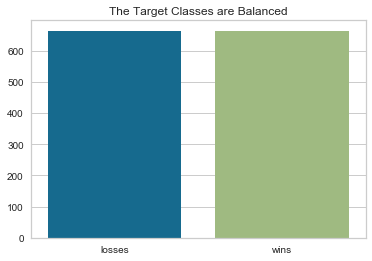

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(y)
plt.xlabel(''), plt.ylabel('')
plt.xticks([0, 1], ('losses', 'wins'))
plt.title('The Target Classes are Balanced');

In [67]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def create_pipe(X_train, clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      (clf_label, clf)])
    return pipe
    
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    """

    # Create pipeline steps for encoding categorical variables, feature scaling and normalization 
    pipe = create_pipe(X_train, clf, clf_label)
    
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

Best Parameters: {'clf__penalty': 'l2', 'clf__C': 100.0}

Training Accuracy: 0.7
Test Accuracy: 0.67



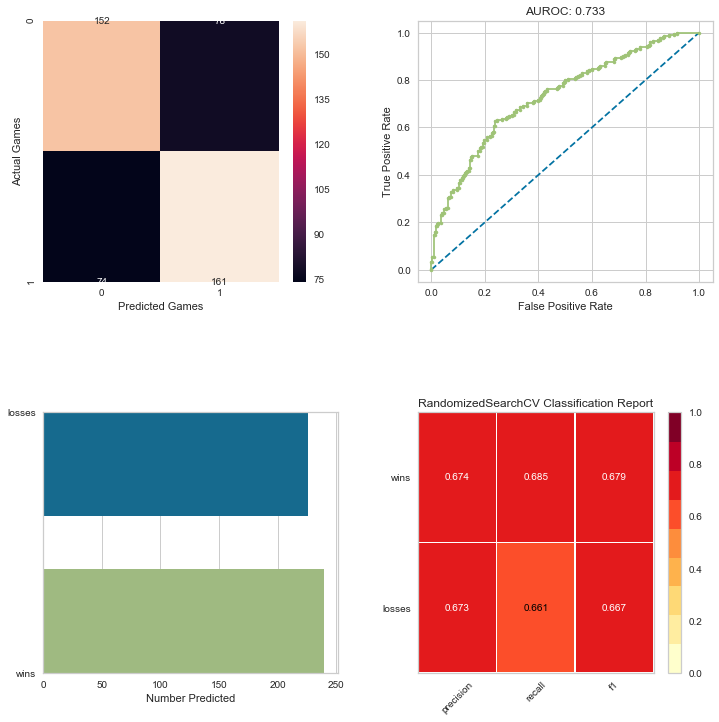

In [68]:
# Tune Logistic Regression for optimal regularization strength
# and regularization method (penalty):
lr_clf = LogisticRegression(random_state=32)
lr_param_grid = {
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['none', 'l2']
}

lr_search, train_accuracy, test_accuracy, auc, logloss = clfy_report(
    lr_clf, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    lr_param_grid, 
    cv=10
)

## Build Bracket, using logistic regression example

In [69]:
df_predict = pd.read_csv('../2019Data/SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [70]:
def get_year_team1_team2(ID):
    """Return a tuple with the year, team1 and team2
    for each ID in the sample submission file of possible matches."""
    return (int(x) for x in ID.split('_'))

In [71]:
df_features

,Season,TeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16
0,2009,1338,1.120465,1.045258,116.678707,97.818416,18.860291,62.892479,0.538654,0.171113,0.411620,0.219762,0.556296,0.700971,56.023250,17.824158,10.411187,10.180942,29.036241,0.373528,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009,1181,1.102060,1.002466,110.278394,94.340557,15.937837,63.271566,0.510867,0.185628,0.370996,0.308217,0.518716,0.666435,55.103019,13.282772,9.886709,11.377683,33.293179,0.371186,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2009,1437,1.118369,0.984487,109.942727,97.558638,12.384090,59.215116,0.519069,0.186701,0.338218,0.301769,0.519554,0.700889,55.918443,15.796355,9.852383,10.805166,34.054664,0.367212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2009,1462,1.106236,0.955972,105.207115,92.059469,13.147646,61.381638,0.517153,0.214339,0.352450,0.330519,0.526842,0.701235,55.311791,14.542962,13.168466,8.716562,32.647218,0.380514,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2009,1199,1.059649,0.946112,99.882173,93.851248,6.030924,57.217405,0.488230,0.227510,0.346105,0.287646,0.498004,0.649902,52.982460,13.114480,14.434504,11.892497,34.260915,0.364537,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,2019,1332,1.080538,0.961862,103.549890,95.681865,7.868025,56.589490,0.506994,0.184159,0.295144,0.240114,0.508892,0.722641,54.026901,13.800886,13.445383,10.650839,39.935689,0.343883,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
738,2019,1414,1.076833,1.007664,108.433361,94.160343,14.273018,61.293840,0.512365,0.170478,0.333987,0.202199,0.530188,0.726388,53.841646,14.307623,11.057385,8.155249,32.073847,0.344693,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
739,2019,1330,1.010790,0.992912,100.152253,92.551490,7.600763,56.460602,0.475783,0.182030,0.309089,0.211315,0.519966,0.730842,50.539491,14.230685,13.240554,8.587803,37.072600,0.329336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
740,2019,1159,1.164683,0.948611,110.153226,102.948562,7.204664,54.908631,0.557054,0.179854,0.272881,0.218326,0.507728,0.742574,58.234154,16.473241,9.839847,9.721854,40.199442,0.355110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [72]:
diff = []
data = []

for i, row in df_predict.iterrows():

    year, team1, team2 = get_year_team1_team2(row.ID)

    # Save 2018 stats/features for the first ID:
    team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

    # Save 2018 stats/features for the first ID:
    team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

    diff = team1 - team2

    data.append(diff)

n_poss_games = len(df_predict)
columns = df_features.columns.get_values()
final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)

In [73]:
predictions = lr_search.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions

df_predict.to_csv('lr_search.csv', index=False)

In [75]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(lr_search, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1583 ± 0.0457,off_rtg
0.1196 ± 0.0162,ie
0.0748 ± 0.0278,sos
0.0718 ± 0.0240,orb_pct
0.0551 ± 0.0381,to_poss
0.0452 ± 0.0403,efg_pct
0.0447 ± 0.0166,four
0.0409 ± 0.0207,def_rtg
0.0323 ± 0.0398,score_op
0.0318 ± 0.0137,drb_pct


In [76]:
# Save the model to be used in Ensemble.ipynb
df_model.to_csv('../2019Data/df_Models2019.csv', index=False)